# Data Collection Phase

In this phase , data is collected from various social media sites like Twitter and Reddit.

## 1. Collecting Data from Twitter using tweepy API

In [ ]:
import tweepy
from tweepy import API 
from tweepy import Cursor
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
 
import twitter_credentials
import numpy as np
import pandas as pd
# # # # TWITTER CLIENT # # # #
class TwitterClient():
    def __init__(self, twitter_user=None):
        self.auth = TwitterAuthenticator().authenticate_twitter_app()
        self.twitter_client = API(self.auth)

        self.twitter_user = twitter_user

    def get_twitter_client_api(self):
        return self.twitter_client

    def get_user_timeline_tweets(self, num_tweets):
        tweets = []
        for tweet in Cursor(self.twitter_client.user_timeline, id=self.twitter_user).items(num_tweets):
            tweets.append(tweet)
        return tweets

    def get_friend_list(self, num_friends):
        friend_list = []
        for friend in Cursor(self.twitter_client.friends, id=self.twitter_user).items(num_friends):
            friend_list.append(friend)
        return friend_list

    def get_home_timeline_tweets(self, num_tweets):
        home_timeline_tweets = []
        for tweet in Cursor(self.twitter_client.home_timeline, id=self.twitter_user).items(num_tweets):
            home_timeline_tweets.append(tweet)
        return home_timeline_tweets


# # # # TWITTER AUTHENTICATER # # # #
class TwitterAuthenticator():

    def authenticate_twitter_app(self):
        auth = OAuthHandler(twitter_credentials.CONSUMER_KEY, twitter_credentials.CONSUMER_SECRET)
        auth.set_access_token(twitter_credentials.ACCESS_TOKEN, twitter_credentials.ACCESS_TOKEN_SECRET)
        return auth

# # # # TWITTER STREAMER # # # #
class TwitterStreamer():
    """
    Class for streaming and processing live tweets.
    """
    def __init__(self):
        self.twitter_autenticator = TwitterAuthenticator()    

    def stream_tweets(self, fetched_tweets_filename, hash_tag_list):
        # This handles Twitter authetification and the connection to Twitter Streaming API
        listener = TwitterListener(fetched_tweets_filename)
        auth = self.twitter_autenticator.authenticate_twitter_app() 
        stream = Stream(auth, listener)

        # This line filter Twitter Streams to capture data by the keywords: 
        stream.filter(track=hash_tag_list)


# # # # TWITTER STREAM LISTENER # # # #
class TwitterListener(StreamListener):
    """
    This is a basic listener that just prints received tweets to stdout.
    """
    def __init__(self, fetched_tweets_filename):
        self.fetched_tweets_filename = fetched_tweets_filename

    def on_data(self, data):
        try:
            print(data)
            with open(self.fetched_tweets_filename, 'a') as tf:
                tf.write(data)
            return True
        except BaseException as e:
            print("Error on_data %s" % str(e))
        return True
          
    def on_error(self, status):
        if status == 420:
            # Returning False on_data method in case rate limit occurs.
            return False
        print(status)


class TweetAnalyzer():
    """
    Functionality for analyzing and categorizing content from tweets.
    """
    def tweets_to_data_frame(self, tweets):
        df = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['Tweets'])

        #df['id'] = np.array([tweet.id for tweet in tweets])
        #df['len'] = np.array([len(tweet.text) for tweet in tweets])
        #df['date'] = np.array([tweet.created_at for tweet in tweets])
        #df['source'] = np.array([tweet.source for tweet in tweets])
        #df['likes'] = np.array([tweet.favorite_count for tweet in tweets])
        #df['retweets'] = np.array([tweet.retweet_count for tweet in tweets])

        return df

 
if __name__ == '__main__':

    twitter_client = TwitterClient()
    tweet_analyzer = TweetAnalyzer()

    api = twitter_client.get_twitter_client_api()

    #tweets = api.user_timeline(screen_name="AUSvIND", count=500)
    search_words = ["#INDvsAUS ", "#indvsaus"]

    date_since = "2020-01-01"

    tweets = tweepy.Cursor(api.search, search_words,
                       geocode="20.5937,78.9629,3000km",
                       lang="en", since=date_since).items(100)

    #print(dir(tweets[0]))
    #print(tweets[0].retweet_count)

    df = tweet_analyzer.tweets_to_data_frame(tweets)
    
    print(df.head(100))
    #df.to_pickle('tweets.pkl')
    df.to_csv('twitterdata.csv')

## 2. Collecting data from Reddit using Praw API

In [ ]:
import praw
import pandas as pd
from praw.models import MoreComments
reddit = praw.Reddit(client_id='MjOYmV5QB4Q8bw', client_secret='Ha-Bem-WhpBXOFu6sQExGW1u760', user_agent='Scraping Example')

"""
# get 10 hot posts from the MachineLearning subreddit
hot_posts = reddit.subreddit('Cricket').hot(limit=10)
for post in hot_posts:
    print(post.title)
"""
#comments = []
comments=""
submission = reddit.submission(id="f1zmjl")
submission.comments.replace_more(limit=0)
for top_level_comment in submission.comments:
    comments = comments + top_level_comment.body
    #comments.append([top_level_comment.body])
#comments = pd.DataFrame(comments,columns=['comment'])
print(comments)
#comments.to_pickle('redditdataset.pkl')
comments.to_csv('redditdataset.csv', sep='.', encoding='utf-8', index=False)

# Data Processing Phase

Performing data mining algorithms on collected data to retrieve information.



## Applying TF-IDF to collected dataset

In [1]:
with open('twitterdata.csv', 'r') as twitterfile:
    twittertext = twitterfile.readlines()
    #twittertext = list(set(twittertext))
    #print(twittertext)
# Converting List to String
twitterdata = ' '.join(map(str, twittertext))
#print(twitterdata)

In [2]:
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
ttokenized_text=sent_tokenize(twitterdata)
ttokenized_word=word_tokenize(twitterdata)

In [3]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/warlock/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
twitterfilter = []
for w in ttokenized_word:
    if w not in stop_words:
        twitterfilter.append(w)
td = ' '.join(map(str, twitterfilter))

In [5]:
import re
two = re.findall(r'\w+', td)
tdi = [i for i in two if not i.isdigit()]
tw = [i for i in tdi if len(i) > 3]
twitterdoc = ' '.join(map(str, tw))

In [6]:
with open('redditdataset.csv', 'r') as redditfile:
    reddittext = redditfile.readlines()
# Converting List to String
redditdata = ' '.join(map(str, reddittext))

In [7]:
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
tokenized_text=sent_tokenize(redditdata)
tokenized_word=word_tokenize(redditdata)

In [8]:
redditfilter = []
for w in tokenized_word:
    if w not in stop_words:
        redditfilter.append(w)
rd = ' '.join(map(str, redditfilter))

In [9]:
import re
rwo = re.findall(r'\w+', rd)
rdi = [i for i in rwo if not i.isdigit()]
fw = [i for i in rdi if len(i) > 3]
redditdoc = ' '.join(map(str, fw))

In [30]:
str_one, str_two = redditdoc[:len(redditdoc)//2],redditdoc[len(redditdoc)//2:] 

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

In [32]:
response = tfidf.fit_transform([str_one, str_two])

In [33]:
tfidfwords = []
feature_names = tfidf.get_feature_names()
for col in response.nonzero()[1]:
    if not feature_names[col].isdigit() and len(feature_names[col]) > 3 and int((response[0, col]) * 100) % 10 != 0:
        print (feature_names[col], ' - ', response[0, col])
        case = {'word': feature_names[col], 'score': response[0, col] }
        tfidfwords.append(case)        

pig2  -  0.013761054704880033
definitely  -  0.013761054704880033
origin  -  0.013761054704880033
punjabi  -  0.04128316411464009
khrriya  -  0.013761054704880033
kidhar  -  0.013761054704880033
retire  -  0.013761054704880033
grandpa  -  0.013761054704880033
eternity  -  0.013761054704880033
whine  -  0.013761054704880033
afghanistan  -  0.013761054704880033
teams  -  0.013761054704880033
lowest  -  0.013761054704880033
individual  -  0.013761054704880033
looked  -  0.013761054704880033
syllabus  -  0.013761054704880033
championship  -  0.013761054704880033
preparation  -  0.013761054704880033
concentration  -  0.013761054704880033
rayudu  -  0.013761054704880033
ambati  -  0.013761054704880033
scooby  -  0.013761054704880033
spanner  -  0.013761054704880033
toes  -  0.027522109409760066
powerful  -  0.013761054704880033
gaandu  -  0.013761054704880033
ground  -  0.013761054704880033
bloke  -  0.013761054704880033
stand  -  0.027522109409760066
reserve  -  0.013761054704880033
basin  

howard  -  0.013761054704880033
kholi  -  0.013761054704880033
falling  -  0.013761054704880033
keeps  -  0.027522109409760066
catching  -  0.013761054704880033
close  -  0.027522109409760066
bothered  -  0.013761054704880033
knuckleball  -  0.013761054704880033
delivery  -  0.013761054704880033
bhenchod  -  0.013761054704880033
excellent  -  0.0195822075204744
what  -  0.0195822075204744
wakes  -  0.013761054704880033
international  -  0.029373311280711602
language  -  0.013761054704880033
speaks  -  0.013761054704880033
player  -  0.0195822075204744
kannadigas  -  0.013761054704880033
three  -  0.06880527352440016
means  -  0.0195822075204744
roots  -  0.013761054704880033
mangalore  -  0.013761054704880033
also  -  0.0195822075204744
right  -  0.048955518801186
vettori  -  0.013761054704880033
bespectacled  -  0.013761054704880033
oram  -  0.013761054704880033
handed  -  0.013761054704880033
left  -  0.05504421881952013
tall  -  0.027522109409760066
patel  -  0.013761054704880033
je

englands  -  0.013761054704880033
under  -  0.013761054704880033
gets  -  0.029373311280711602
kyle  -  0.027522109409760066
cricket  -  0.13707545264332083
sport  -  0.05504421881952013
stuff  -  0.027522109409760066
https  -  0.013761054704880033
source  -  0.029373311280711602
warm  -  0.013761054704880033
bowling  -  0.146866556403558
strength  -  0.013761054704880033
full  -  0.0195822075204744
near  -  0.013761054704880033
piss  -  0.027522109409760066
belting  -  0.013761054704880033
century  -  0.0391644150409488
blade  -  0.013761054704880033
fluke  -  0.013761054704880033
innings  -  0.0881199338421348
cameo  -  0.013761054704880033
face  -  0.0195822075204744
handful  -  0.013761054704880033
jamieson  -  0.0881199338421348
future  -  0.04128316411464009
excited  -  0.013761054704880033
fuck  -  0.058746622561423205
career  -  0.04128316411464009
make  -  0.048955518801186
india  -  0.24477759400593002
exists  -  0.013761054704880033
bowler  -  0.048955518801186
edit  -  0.01

In [34]:
#sorting the list in ascending order , taking the word value and reversing the final list
tfsorted = []
words = []
tfsorted = sorted(tfidfwords, key = lambda i: i['score']) 
#print(tfsorted)
words = [d['word'] for d in tfsorted]
words.reverse()
#making list distinct
from collections import OrderedDict
asp = list(dict.fromkeys(words))
asp = [x for x in asp if x != 'https']

In [35]:
print("Fans Mostly discussed about : ",asp[:10])

Fans Mostly discussed about :  ['series', 'india', 'kohli', 'saini', 'like', 'bowling', 'rahul', 'cricket', 'bumrah', 'thakur']


In [70]:
fdt = redditdata
wlist = asp[:10]
fdt = fdt.replace("Bumrah", "bumrah")

In [71]:
fre = []
for i in wlist:
    dl = []
    for sentence in fdt.split('.'):
        if i in sentence:
                dl.append(sentence + '.')
    fre.append(dl)

In [85]:
rd = ' '.join(map(str, fre[9][:5]))
print(rd)

 3-0 is an entirely accurate reflection of the scoreline
 "Shardul thakur throughout this series
 
 28. 
 Man is Jadeja just not confident in his striking anymore, keeps giving strike to Saini
 Saini currently averages over 50 (with the bat) in ODI cricket!
 Pant demoted from International cricketer to crowd supporter
 I wish for a 10 wicket loss, wont change anything with selection as koach and bewda are adamant on sub par players like thakur but NZ deserve to win the series in grand style.  Is that legal?
 God we are the biggest chokers in international sport
 why does thakur keep bowling short every over dumbass
 we are all npcs in colins world
 Saini had an off day and still he looks like he could pick a wicket any ball. 
 The test series sure will be tasty
 Idk about you gois but my man of the series is Lord thakur
 ">30th over
 
 >Southee with 5 overs left
 
 I feel like we should've learned the flaw in this plan by now. "
 How does the ball always go to Kohli no matter where he 

In [ ]:
re.findall(r"([^.]*?Bumrah[^.]*\.)",fdt)

## Applying K-Means Clustering on Dataset

In [86]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

In [87]:
#combining reddit and twitter data
finaldatatext = fw

In [88]:
#making the list distinct for processing
finaldatatext = list(set(finaldatatext))
len(finaldatatext)

1671

In [89]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(finaldatatext)

In [90]:
true_k = 3
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=3, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [91]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

In [92]:
clusterlists = []
for i in range(true_k):
    dummy_list  = []
    for ind in order_centroids[i]:
        #print( '%s' % terms[ind])
        dummy_list.append('%s' % terms[ind])
    clusterlists.append(dummy_list)

In [26]:
btkeywords = ['bat', 'batting',]
bowkeywords = ['bowling', 'spinner','spin']
fieldkeywords = ['catch', 'fielding', 'keeper']

In [31]:
bt = []  
bw = []  
fd = []
if i in btkeywords and i in clusterlists[0][1000]:
    bt = clusterlists[0][1000]
elif i in btkeywords and i in clusterlists[1][1000]:
    bt = clusterlists[1][1000]
else:
    bt = clusterlists[2][1000]
        
    

In [93]:
len(clusterlists[1])

1392

In [94]:
len(clusterlists[2])

1392

In [ ]:
import more_itertools as mit

result = list(mit.split_at(clusterlist, pred=lambda x: set(x) & {"\nCluster 1:"}))
sublist_1, sublist_2, sublist_3 = result


In [ ]:
print('\n')
print('Prediction')
X = vectorizer.transform(redditdata)
predicted = model.predict(X)
print(predicted)

# Sentiment Analysis using NLTK

In [35]:
import pandas as pd
messages = [line.rstrip() for line in open("redditdataset.csv")]
data = pd.read_csv("redditdataset.csv",sep="\n",names=["message"])

In [36]:
data["message"][1]
#just to check if datacorpus is loaded currectly.

'So this is the worst series of Kohli like in years.'

In [37]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/warlock/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [38]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [39]:
sid = SentimentIntensityAnalyzer()

In [40]:
summary = {"positive":0,"neutral":0,"negative":0}
for x in messages: 
    ss = sid.polarity_scores(x)
    if ss["compound"] == 0.0: 
        summary["neutral"] +=1
    elif ss["compound"] > 0.0:
        summary["positive"] +=1
    else:
        summary["negative"] +=1
print(summary)

{'positive': 206, 'neutral': 448, 'negative': 140}


In [41]:
type(summary)

dict

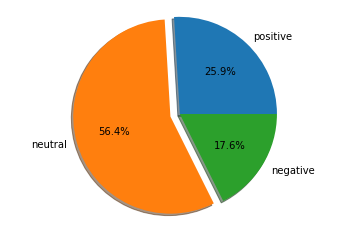

In [43]:
import matplotlib.pyplot as plt
labels = tuple(summary.keys())
sizes = list(summary.values())
explode = (0, 0.1, 0)
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True)
plt.axis('equal')
plt.show()